# ***Import Libraries***

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# ***Load Dataset***

In [2]:
# Function to load and preprocess the dataset
def load_dataset(data_dir):
    images = []
    labels = []

    for color in os.listdir(data_dir):
        color_path = os.path.join(data_dir, color)
        if os.path.isdir(color_path):
            for filename in os.listdir(color_path):
                img_path = os.path.join(color_path, filename)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                img = cv2.resize(img, (64, 64))  # Resize for consistency
                images.append(img)
                labels.append(color)

    return np.array(images), np.array(labels)

In [3]:
# Load the dataset
data_directory = '/kaggle/input/6000-store-items-images-classified-by-color/train'
images, labels = load_dataset(data_directory)

# ***Data Preprocessing***

In [4]:
# Convert labels to one-hot encoding
label_mapping = {label: idx for idx, label in enumerate(np.unique(labels))}
labels_encoded = np.array([label_mapping[label] for label in labels])
labels_one_hot = tf.keras.utils.to_categorical(labels_encoded)

In [5]:
# Split the dataset into training and valdiation sets
X_train, X_test, y_train, y_test = train_test_split(images, labels_one_hot, test_size=0.2, random_state=42)

In [6]:
# Normalize pixel values to [0, 1]
X_train, X_test = X_train / 255.0, X_test / 255.0

In [7]:
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
datagen.fit(X_train)

# ***Modeling***

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(64, 64, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5)) 
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(label_mapping), activation='softmax'))

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 13, 13, 128)       0         
 g2D)                                                   

# ***Training***

In [11]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
          steps_per_epoch=len(X_train) / 32, epochs=100,
          validation_data=(X_test, y_test))

Epoch 1/100
155/155 [==============================] - 13s 46ms/step - loss: 2.2698 - accuracy: 0.1996 - val_loss: 1.8291 - val_accuracy: 0.3798
Epoch 2/100
155/155 [==============================] - 7s 42ms/step - loss: 1.7813 - accuracy: 0.3905 - val_loss: 1.5043 - val_accuracy: 0.5064
Epoch 3/100
155/155 [==============================] - 7s 42ms/step - loss: 1.4661 - accuracy: 0.4965 - val_loss: 1.3505 - val_accuracy: 0.5232
Epoch 4/100
155/155 [==============================] - 6s 41ms/step - loss: 1.2765 - accuracy: 0.5774 - val_loss: 1.0933 - val_accuracy: 0.6202
Epoch 5/100
155/155 [==============================] - 7s 43ms/step - loss: 1.2350 - accuracy: 0.5947 - val_loss: 1.2054 - val_accuracy: 0.6098
Epoch 6/100
155/155 [==============================] - 6s 41ms/step - loss: 1.1464 - accuracy: 0.6189 - val_loss: 0.9863 - val_accuracy: 0.6795
Epoch 7/100
155/155 [==============================] - 6s 41ms/step - loss: 1.1328 - accuracy: 0.6392 - val_loss: 1.0168 - val_accuracy

# ***Evalution***

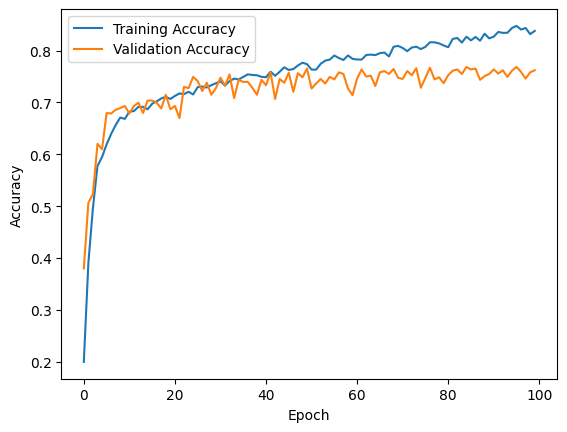

In [12]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

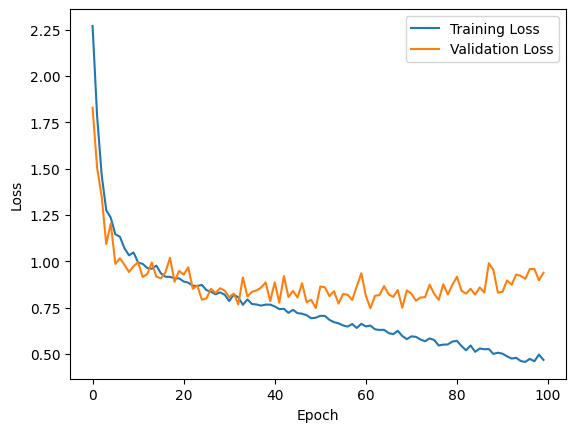

In [13]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# ***Saving Model***

In [14]:
# Save the trained model
model.save('color_detection_model.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# ***Predicting and Testing***

In [20]:
sample_image_path = '/kaggle/input/6000-store-items-images-classified-by-color/test/1000000033.jpg'
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = cv2.resize(sample_image, (64, 64))

sample_image = sample_image / 255.0

sample_image = np.reshape(sample_image, (1, 64, 64, 3))

# Make a prediction
prediction = model.predict(sample_image)
predicted_label = np.argmax(prediction)
predicted_color = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_label)]

print("Predicted Color:", predicted_color)
if predicted_color=='purple':
    print('Prediction is true')
else: print('Prediction is false')

1/1 [==============================] - 0s 20ms/step
Predicted Color: purple
Prediction is true


In [22]:
sample_image_path = '/kaggle/input/6000-store-items-images-classified-by-color/test/1000000678.jpg'
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = cv2.resize(sample_image, (64, 64))

sample_image = sample_image / 255.0

sample_image = np.reshape(sample_image, (1, 64, 64, 3))

prediction = model.predict(sample_image)
predicted_label = np.argmax(prediction)
predicted_color = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_label)]

print("Predicted Color:", predicted_color)
if predicted_color=='yellow':
    print('Prediction is true')
else: print('Prediction is false')

1/1 [==============================] - 0s 20ms/step
Predicted Color: green
Prediction is false


In [29]:
sample_image_path = '/kaggle/input/6000-store-items-images-classified-by-color/test/1000007677.jpg'
sample_image = cv2.imread(sample_image_path)
sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
sample_image = cv2.resize(sample_image, (64, 64))

sample_image = sample_image / 255.0

sample_image = np.reshape(sample_image, (1, 64, 64, 3))

prediction = model.predict(sample_image)
predicted_label = np.argmax(prediction)
predicted_color = list(label_mapping.keys())[list(label_mapping.values()).index(predicted_label)]

print("Predicted Color:", predicted_color)
if predicted_color=='pink':
    print('Prediction is true')
else: print('Prediction is false')

1/1 [==============================] - 0s 19ms/step
Predicted Color: pink
Prediction is true


In [18]:
import IPython.display as ipd
import numpy as np
ipd.Audio(np.sin(2*np.pi*500*np.arange(5000*2)/5000), rate=10000, autoplay=True)